In [1]:
#General stuff
import time
import datetime
import glob
import re
import pandas as pd
from collections import Counter
import progressbar
import jellyfish
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import statsmodels.formula.api as smf
from collections import Counter
from itertools import chain

## Pulling in all the files

In [2]:
df = pd.read_csv('data/df_final_harm.csv')

## I want to look for repetitions "sozialrechtliche Abteilungen"
And I'm working with the years, as the whole long string consisting of 15'000 verdicts is just too long. The Kernel dies regularly. Which really isn't much fun.

In [3]:
df_sozrecht = df[df['recht_harm'] == 'Sozialrecht']
sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']['Text-Nummer']

Splitting up the lists.

In [4]:
l = list(sozrecht)
n = 1000
txt_lsts = [l[i:i + n] for i in range(0, len(l), n)]

In [5]:
df_ = pd.DataFrame(columns=['index', 0])
bar = progressbar.ProgressBar()

for txt_lst, i in zip(txt_lsts, bar(range(len(txt_lsts)))):

    long_str = ''
    
    for txt in txt_lst:
    
        file = open('txt_files/' + txt, 'r')
        text = file.read()
        #Making sure the line breaks '/n', 'xa0' and double spaces are removed
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', ' ')
        #Removing these automated notifications
        text = text.replace('Wichtiger Hinweis:Diese Website wird in älteren Versionen von Netscape ohne graphische Elemente dargestellt. Die Funktionalität der Website ist aber trotzdem gewährleistet. Wenn Sie diese Website regelmässig benutzen, empfehlen wir Ihnen, auf Ihrem Computer einen aktuellen Browser zu installieren.Zurück zur Einstiegsseite Drucken Grössere Schrift', '')
        text = text.replace('Vorwärts ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
        text = text.replace('Bundesgericht Tribunal fédéral Tribunale federale Tribunal federal', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang: Zurück 180', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang:1 ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
    
        long_str = long_str + text
        
    df_new = pd.DataFrame(pd.Series( long_str[ix:ix+500] for ix in list(range(len(long_str))) ).value_counts()).reset_index()
    df_new = df_new[df_new[0]> 1]
    
    frames = [df_, df_new]
    df_ = pd.concat(frames)
    

 93% (15 of 16) |########################  | Elapsed Time: 0:11:48 ETA: 0:00:47

# Renaming columns
Later, I can just jump to this step, I don't need to repeat the steps above

In [8]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2617636 entries, 0 to 11943
Data columns (total 2 columns):
index    object
0        float64
dtypes: float64(1), object(1)
memory usage: 59.9+ MB


In [9]:
df_.columns = [['String', 'Count']]

# Deleting Duplicates

In [10]:
df_ = df_.drop_duplicates(subset='String', keep='first')

In [11]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993961 entries, 0 to 11943
Data columns (total 2 columns):
String    object
Count     float64
dtypes: float64(1), object(1)
memory usage: 45.6+ MB


In [12]:
df = df_[df_['Count'] >= 10]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21024 entries, 0 to 3481
Data columns (total 2 columns):
String    21024 non-null object
Count     21024 non-null float64
dtypes: float64(1), object(1)
memory usage: 492.8+ KB


# Matching similar Strings
Using Jellyfish and remodelling the original df, using it to create a new list of string. Because these ones are the ones I don't need to consider anymore.

In [14]:
df_new = pd.DataFrame(columns=['String', 'Count', 'Jaro'])

for count in range(1000):
    
    print(count)
    string_list = list(df['String'])
    value_list = []
    bar = progressbar.ProgressBar()

    for elem, i in zip(string_list, bar(range(len(string_list)))):
    
        value = jellyfish.jaro_distance(string_list[0], elem)
        value_list.append(value)
    
    df['Jaro'] = value_list
    df_unique = df[df['Jaro'] >= .825].head(1)

    frames = [df_new, df_unique]
    df_new = pd.concat(frames)

    df = df[df['Jaro'] <= .825]
    del df['Jaro']

  2% (493 of 21024) |                      | Elapsed Time: 0:00:00 ETA: 0:00:04

0


 98% (20701 of 21024) |################### | Elapsed Time: 0:00:04 ETA: 0:00:00/Users/barneyjs/.virtualenvs/master/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
  3% (792 of 20832) |                      | Elapsed Time: 0:00:00 ETA: 0:00:03

1


  5% (1052 of 20777) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

2


  5% (1051 of 20750) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

3


  2% (523 of 20713) |                      | Elapsed Time: 0:00:00 ETA: 0:00:03

4


  5% (1046 of 20649) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

5


  5% (1032 of 20363) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

6


  5% (1025 of 20225) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

7


  5% (1023 of 20198) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:03

8


  5% (1018 of 20100) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

9


  4% (934 of 20065) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

10


  5% (1015 of 20035) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

11


  5% (1013 of 20004) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

12


  5% (1012 of 19969) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

13


  3% (758 of 19958) |                      | Elapsed Time: 0:00:00 ETA: 0:00:03

14


  3% (758 of 19944) |                      | Elapsed Time: 0:00:00 ETA: 0:00:03

15


  5% (1008 of 19891) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

16


  5% (1003 of 19803) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

17


  5% (998 of 19702) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

18


  5% (994 of 19623) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

19


  5% (983 of 19408) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

20


  5% (981 of 19372) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

21


  5% (978 of 19297) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

22


  5% (973 of 19202) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

23


  5% (971 of 19159) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

24


  5% (967 of 19088) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

25


  5% (966 of 19059) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

26


  5% (965 of 19043) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

27


  5% (964 of 19032) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

28


  5% (964 of 19023) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

29


  5% (963 of 19014) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

30


  5% (961 of 18971) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

31


  5% (957 of 18889) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

32


  5% (956 of 18875) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

33


  5% (953 of 18819) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

34


  5% (953 of 18810) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

35


  7% (1426 of 18773) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

36


  5% (949 of 18742) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

37


  5% (945 of 18662) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

38


  5% (942 of 18590) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

39


  5% (939 of 18543) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

40


  5% (937 of 18501) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

41


  5% (935 of 18464) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

42


  5% (932 of 18399) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

43


  7% (1393 of 18340) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

44


  7% (1384 of 18220) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

45


  5% (920 of 18159) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

46


  5% (917 of 18107) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

47


  5% (916 of 18082) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

48


  7% (1371 of 18041) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

49


  7% (1369 of 18019) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

50


  7% (1368 of 18006) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

51


  5% (910 of 17968) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

52


  5% (910 of 17954) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

53


  7% (1362 of 17930) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

54


  7% (1360 of 17903) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

55


  7% (1357 of 17861) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

56


  5% (902 of 17807) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

57


  5% (901 of 17787) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

58


  5% (900 of 17767) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

59


  5% (898 of 17729) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

60


  5% (898 of 17720) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

61


  7% (1343 of 17671) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

62


  7% (1336 of 17588) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

63


  7% (1329 of 17492) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

64


  7% (1326 of 17455) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

65


  7% (1320 of 17367) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

66


  5% (878 of 17339) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:03

67


  6% (1095 of 17300) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

68


  7% (1311 of 17254) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

69


  7% (1308 of 17214) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

70


  7% (1306 of 17194) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

71


  7% (1305 of 17176) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

72


  6% (1085 of 17129) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

73


  7% (1299 of 17102) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

74


  7% (1298 of 17089) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

75


  7% (1296 of 17062) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

76


  5% (864 of 17056) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

77


  7% (1296 of 17054) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

78


  7% (1287 of 16933) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

79


  5% (853 of 16840) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:02

80


  7% (1276 of 16797) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

81


  7% (1271 of 16732) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

82


  7% (1267 of 16681) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

83


  7% (1265 of 16646) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

84


  7% (1259 of 16567) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

85


  7% (1257 of 16540) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

86


  7% (1255 of 16522) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

87


  7% (1252 of 16484) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

88


  7% (1251 of 16467) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

89


  7% (1250 of 16448) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

90


  7% (1248 of 16428) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

91


  7% (1248 of 16421) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

92


  7% (1244 of 16368) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

93


  7% (1237 of 16287) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

94


  7% (1235 of 16257) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

95


  7% (1232 of 16209) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

96


  7% (1229 of 16174) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

97


  7% (1227 of 16151) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

98


  7% (1227 of 16150) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

99


  7% (1224 of 16108) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

100


  7% (1219 of 16044) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

101


  7% (1213 of 15969) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

102


  7% (1209 of 15913) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

103


  7% (1204 of 15840) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

104


  7% (1199 of 15777) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

105


  7% (1197 of 15753) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

106


  7% (1194 of 15721) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

107


  7% (1191 of 15671) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

108


  7% (1184 of 15589) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

109


  7% (1177 of 15486) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

110


  7% (1173 of 15432) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

111


  7% (1168 of 15375) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

112


  7% (1166 of 15352) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

113


  7% (1161 of 15279) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

114


  7% (1156 of 15209) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

115


  7% (1153 of 15173) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

116


  7% (1150 of 15129) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

117


  7% (1148 of 15107) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

118


  7% (1146 of 15082) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

119


  7% (1143 of 15040) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

120


  7% (1141 of 15017) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

121


  7% (1138 of 14979) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

122


  8% (1326 of 14957) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

123


  7% (1133 of 14916) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

124


  7% (1132 of 14904) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

125


  7% (1130 of 14877) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

126


  7% (1129 of 14864) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

127


  7% (1128 of 14852) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

128


  7% (1125 of 14801) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

129


  7% (1124 of 14797) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

130


  7% (1124 of 14794) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

131


  7% (1123 of 14784) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

132


  7% (1123 of 14776) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

133


  7% (1122 of 14771) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

134


  7% (1122 of 14762) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

135


  7% (1121 of 14754) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

136


  7% (1119 of 14729) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

137


  7% (1116 of 14692) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

138


  7% (1114 of 14663) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

139


  7% (1110 of 14613) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

140


  7% (1108 of 14587) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

141


  7% (1107 of 14567) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

142


  7% (1106 of 14557) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

143


  7% (1104 of 14527) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

144


  7% (1104 of 14526) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

145


  7% (1103 of 14515) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

146


  7% (1100 of 14471) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

147


  7% (1098 of 14446) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

148


  8% (1274 of 14370) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

149


  7% (1085 of 14280) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

150


  8% (1261 of 14227) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

151


  7% (1077 of 14172) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

152


  8% (1250 of 14100) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

153


  8% (1242 of 14007) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

154


  8% (1234 of 13920) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

155


  8% (1228 of 13853) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

156


  8% (1225 of 13817) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

157


  8% (1222 of 13788) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

158


  8% (1220 of 13766) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

159


  7% (1041 of 13702) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

160


  8% (1211 of 13664) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

161


  8% (1206 of 13600) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

162


  8% (1201 of 13549) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

163


  7% (1028 of 13533) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

164


  8% (1196 of 13490) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

165


  8% (1191 of 13435) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

166


  7% (1019 of 13412) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

167


  7% (1018 of 13401) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

168


  7% (1018 of 13391) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

169


  7% (1017 of 13390) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

170


  7% (1017 of 13385) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

171


  7% (1015 of 13362) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

172


  7% (1015 of 13358) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

173


  7% (1014 of 13346) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

174


  7% (1012 of 13323) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

175


  7% (1010 of 13297) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

176


  7% (1010 of 13291) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

177


  7% (1010 of 13289) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

178


  7% (1010 of 13288) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

179


  7% (1010 of 13286) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

180


  7% (1009 of 13285) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:02

181


  7% (1009 of 13282) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

182


  7% (1009 of 13280) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

183


  7% (1006 of 13238) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

184


  7% (1006 of 13237) |#                    | Elapsed Time: 0:00:00 ETA: 0:00:01

185


  7% (990 of 13026) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

186


 10% (1271 of 12544) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

187


  7% (949 of 12493) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

188


  7% (947 of 12457) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

189


  7% (942 of 12396) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

190


  7% (931 of 12251) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

191


  7% (926 of 12181) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

192


  7% (922 of 12130) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

193


  7% (919 of 12088) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

194


  7% (912 of 12005) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

195


 10% (1196 of 11804) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

196


  7% (895 of 11780) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

197


 11% (1337 of 11729) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

198


  7% (886 of 11665) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

199


  7% (883 of 11624) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

200


  7% (880 of 11582) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

201


 11% (1313 of 11517) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

202


  7% (869 of 11434) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

203


  7% (865 of 11386) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

204


  7% (859 of 11305) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

205


 11% (1281 of 11244) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

206


  7% (851 of 11201) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

207


  7% (849 of 11175) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

208


  7% (845 of 11119) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

209


  7% (841 of 11066) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

210


 11% (1254 of 10999) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

211


 11% (1243 of 10903) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

212


 11% (1241 of 10892) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

213


 11% (1230 of 10790) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

214


 11% (1229 of 10785) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

215


 11% (1222 of 10718) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

216


 11% (1218 of 10684) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

217


 11% (1212 of 10630) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

218


 11% (1206 of 10585) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

219


 11% (1201 of 10542) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

220


 11% (1195 of 10483) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

221


 11% (1190 of 10443) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

222


 11% (1188 of 10427) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

223


 11% (1186 of 10407) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

224


 11% (1183 of 10381) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

225


 11% (1170 of 10270) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

226


 11% (1162 of 10193) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

227


 11% (1159 of 10170) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

228


 11% (1156 of 10143) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

229


 11% (1154 of 10122) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

230


 11% (1148 of 10076) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

231


 11% (1141 of 10015) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

232


 11% (1134 of 9946) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

233


 11% (1130 of 9915) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

234


 11% (1123 of 9849) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

235


 11% (1120 of 9826) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

236


 11% (1113 of 9763) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

237


 11% (1107 of 9714) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

238


 11% (1105 of 9695) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

239


 12% (1227 of 9689) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

240


 11% (1097 of 9625) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

241


 11% (1092 of 9580) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

242


 11% (1089 of 9558) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

243


 11% (1084 of 9513) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

244


 11% (1082 of 9491) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

245


 11% (1076 of 9443) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

246


 11% (1075 of 9436) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

247


 11% (1075 of 9431) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

248


 11% (1075 of 9428) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

249


 11% (1073 of 9417) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

250


 12% (1190 of 9399) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

251


 11% (1066 of 9350) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

252


 11% (1062 of 9321) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

253


 11% (1062 of 9317) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

254


 11% (1061 of 9306) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

255


 11% (1056 of 9264) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

256


 11% (1052 of 9231) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

257


 12% (1166 of 9206) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

258


 11% (1047 of 9182) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

259


 11% (1043 of 9152) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

260


 11% (1039 of 9113) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

261


 11% (1037 of 9098) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

262


 11% (1036 of 9090) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

263


 11% (1036 of 9086) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

264


 11% (1035 of 9083) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

265


 11% (1035 of 9080) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

266


 12% (1150 of 9079) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

267


 11% (1033 of 9065) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

268


 11% (1033 of 9064) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

269


 11% (1032 of 9057) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

270


 11% (1031 of 9047) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

271


 11% (1031 of 9046) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

272


 11% (1030 of 9041) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

273


 11% (1029 of 9032) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

274


 11% (1029 of 9031) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

275


 11% (1029 of 9028) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

276


 11% (1029 of 9027) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

277


 11% (1028 of 9023) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

278


 11% (1028 of 9022) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

279


 11% (1025 of 8993) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

280


 11% (1025 of 8992) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

281


 11% (1025 of 8990) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

282


 11% (1025 of 8989) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

283


 12% (1123 of 8867) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

284


 12% (1116 of 8815) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

285


 11% (997 of 8748) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

286


 11% (991 of 8691) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

287


 13% (1204 of 8644) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

288


 11% (979 of 8591) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

289


 11% (971 of 8523) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

290


 10% (859 of 8480) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

291


 13% (1163 of 8346) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

292


 13% (1157 of 8303) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

293


 13% (1149 of 8245) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

294


 11% (931 of 8170) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

295


 15% (1236 of 8133) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

296


 15% (1226 of 8065) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

297


 15% (1219 of 8025) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

298


  8% (707 of 7978) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:02

299


 11% (901 of 7908) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

300


 15% (1199 of 7889) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

301


 15% (1187 of 7810) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

302


 15% (1183 of 7788) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

303


 15% (1174 of 7727) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

304


 15% (1168 of 7684) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

305


 15% (1157 of 7615) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

306


 13% (1048 of 7522) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

307


 13% (1041 of 7473) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

308


 12% (938 of 7403) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

309


 12% (935 of 7379) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

310


 11% (832 of 7302) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

311


 15% (1101 of 7248) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

312


 15% (1089 of 7165) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

313


 15% (1084 of 7134) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

314


 15% (1078 of 7096) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

315


 15% (1068 of 7031) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

316


 15% (1068 of 7025) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

317


 15% (1061 of 6980) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

318


 15% (1053 of 6931) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

319


 15% (1053 of 6926) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

320


 15% (1048 of 6896) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

321


 15% (1040 of 6845) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

322


 15% (1035 of 6809) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

323


 15% (1032 of 6792) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

324


 16% (1117 of 6784) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

325


 15% (1027 of 6758) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

326


 15% (1027 of 6755) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

327


 15% (1021 of 6721) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

328


 16% (1100 of 6680) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

329


 17% (1177 of 6639) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

330


 18% (1255 of 6607) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

331


 15% (999 of 6573) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

332


 15% (995 of 6549) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

333


 15% (987 of 6492) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

334


 17% (1146 of 6465) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

335


 17% (1140 of 6431) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

336


 17% (1136 of 6406) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

337


 16% (1051 of 6384) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

338


 17% (1131 of 6379) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

339


 19% (1206 of 6347) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

340


 16% (1039 of 6312) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

341


 18% (1195 of 6290) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

342


 18% (1188 of 6255) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

343


 17% (1101 of 6208) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

344


 18% (1173 of 6174) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

345


 17% (1091 of 6154) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

346


 17% (1088 of 6137) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

347


 15% (929 of 6115) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

348


 17% (1083 of 6108) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

349


 17% (1081 of 6096) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

350


 18% (1154 of 6075) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

351


 18% (1149 of 6050) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

352


 17% (1072 of 6045) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

353


 17% (1071 of 6042) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

354


 16% (994 of 6036) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

355


 18% (1145 of 6028) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

356


 17% (1067 of 6019) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

357


 16% (988 of 5998) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

358


 17% (1061 of 5984) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

359


 18% (1136 of 5982) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

360


 17% (1058 of 5970) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

361


 18% (1131 of 5954) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

362


 17% (1054 of 5946) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

363


 18% (1125 of 5925) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

364


 19% (1121 of 5900) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

365


 19% (1117 of 5878) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

366


 19% (1114 of 5863) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

367


 18% (1113 of 5859) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

368


 18% (1112 of 5853) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

369


 18% (1111 of 5850) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

370


 18% (1110 of 5843) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

371


 18% (1109 of 5840) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

372


 19% (1109 of 5836) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

373


 18% (1108 of 5834) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

374


 17% (1034 of 5830) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

375


 18% (1107 of 5829) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

376


 17% (1033 of 5828) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

377


 18% (1107 of 5827) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

378


 18% (1105 of 5818) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

379


 18% (1101 of 5795) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

380


 19% (1101 of 5794) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

381


 18% (1091 of 5743) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

382


 20% (1158 of 5713) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

383


 20% (1151 of 5680) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

384


 20% (1141 of 5632) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

385


 20% (1129 of 5570) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

386


 19% (1050 of 5526) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

387


 21% (1184 of 5502) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

388


 22% (1246 of 5466) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

389


 21% (1166 of 5415) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

390


 22% (1227 of 5382) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

391


 21% (1152 of 5349) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

392


 22% (1207 of 5297) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

393


 22% (1201 of 5271) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

394


 22% (1196 of 5247) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

395


 21% (1129 of 5245) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

396


 21% (1121 of 5208) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

397


 21% (1107 of 5140) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

398


 22% (1156 of 5072) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

399


 21% (1077 of 5002) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

400


 22% (1135 of 4981) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

401


 21% (1070 of 4968) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

402


 20% (995 of 4909) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

403


 22% (1113 of 4883) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

404


 24% (1165 of 4840) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

405


 21% (1041 of 4837) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

406


 22% (1099 of 4823) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

407


 24% (1158 of 4814) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

408


 22% (1094 of 4800) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

409


 21% (1023 of 4751) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

410


 22% (1073 of 4705) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

411


 22% (1057 of 4639) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

412


 24% (1111 of 4617) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

413


 24% (1110 of 4612) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

414


 20% (932 of 4598) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

415


 22% (1047 of 4591) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

416


 24% (1104 of 4587) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

417


 24% (1103 of 4586) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

418


 24% (1075 of 4468) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

419


 26% (1173 of 4409) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

420


 25% (1092 of 4310) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

421


 26% (1130 of 4249) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

422


 25% (1068 of 4218) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

423


 24% (1009 of 4193) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

424


 26% (1108 of 4167) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

425


 27% (1151 of 4130) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

426


 29% (1177 of 4042) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

427


 27% (1115 of 4002) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

428


 27% (1098 of 3942) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

429


 30% (1184 of 3896) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

430


 29% (1132 of 3885) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

431


 27% (1078 of 3870) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

432


 29% (1110 of 3812) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

433


 30% (1157 of 3806) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

434


 29% (1107 of 3800) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

435


 29% (1101 of 3781) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

436


 26% (1005 of 3780) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

437


 25% (955 of 3771) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

438


 30% (1142 of 3758) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

439


 31% (1175 of 3710) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

440


 30% (1114 of 3664) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

441


 31% (1143 of 3609) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

442


 31% (1128 of 3562) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

443


 30% (1074 of 3533) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

444


 30% (1068 of 3514) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

445


 30% (1061 of 3491) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

446


 31% (1104 of 3486) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

447


 30% (1059 of 3485) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

448


 30% (1058 of 3481) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

449


 30% (1058 of 3480) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

450


 31% (1083 of 3420) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

451


 32% (1121 of 3405) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

452


 26% (897 of 3374) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

453


 30% (1014 of 3336) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

454


 21% (718 of 3334) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

455


 29% (970 of 3329) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

456


 30% (1012 of 3328) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

457


 32% (1094 of 3324) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

458


 30% (1010 of 3323) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

459


 31% (1040 of 3284) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

460


 32% (1076 of 3268) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

461


 31% (1033 of 3262) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

462


 31% (1020 of 3221) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

463


 32% (1044 of 3172) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

464


 32% (1029 of 3126) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

465


 34% (1058 of 3094) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

466


 34% (1057 of 3090) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

467


 34% (1053 of 3080) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

468


 34% (1051 of 3073) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

469


 34% (1043 of 3050) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

470


 25% (772 of 3047) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

471


 34% (1042 of 3046) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

472


 35% (1079 of 3044) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

473


 35% (1057 of 2982) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

474


 34% (1008 of 2947) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

475


 36% (1072 of 2919) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

476


 37% (1105 of 2909) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

477


 39% (1093 of 2785) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

478


 38% (1014 of 2668) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

479


 43% (1088 of 2526) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

480


 44% (1082 of 2442) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

481


 44% (1053 of 2376) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

482


 43% (1005 of 2334) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

483


 48% (1078 of 2240) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

484


 49% (1049 of 2124) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

485


 49% (1036 of 2097) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

486


 55% (1079 of 1936) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

487


 56% (1068 of 1874) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

488


 56% (1065 of 1869) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

489


 53% (976 of 1835) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

490


 60% (1097 of 1804) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

491


 63% (1095 of 1730) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

492


 63% (1075 of 1698) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

493


 63% (1056 of 1667) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

494


 63% (1029 of 1625) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

495


 64% (1011 of 1565) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

496


 67% (1035 of 1542) |##############        | Elapsed Time: 0:00:00 ETA: 0:00:00

497


 70% (1057 of 1491) |###############       | Elapsed Time: 0:00:00 ETA: 0:00:00

498


 69% (1022 of 1467) |###############       | Elapsed Time: 0:00:00 ETA: 0:00:00

499


 68% (984 of 1439) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

500


 70% (987 of 1391) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

501


 73% (1020 of 1388) |################      | Elapsed Time: 0:00:00 ETA: 0:00:00

502


 72% (988 of 1368) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

503


 74% (1021 of 1367) |################      | Elapsed Time: 0:00:00 ETA: 0:00:00

504


 77% (1055 of 1366) |################      | Elapsed Time: 0:00:00 ETA: 0:00:00

505


 79% (1068 of 1339) |#################     | Elapsed Time: 0:00:00 ETA: 0:00:00

506


 79% (1049 of 1315) |#################     | Elapsed Time: 0:00:00 ETA: 0:00:00

507


 63% (810 of 1279) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

508


 79% (1005 of 1260) |#################     | Elapsed Time: 0:00:00 ETA: 0:00:00

509


 87% (1068 of 1222) |###################   | Elapsed Time: 0:00:00 ETA: 0:00:00

510


 87% (1035 of 1185) |###################   | Elapsed Time: 0:00:00 ETA: 0:00:00

511


 88% (1002 of 1130) |###################   | Elapsed Time: 0:00:00 ETA: 0:00:00

512


 86% (958 of 1112) |###################    | Elapsed Time: 0:00:00 ETA: 0:00:00

513


 92% (994 of 1075) |#####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

514


 97% (1027 of 1053) |##################### | Elapsed Time: 0:00:00 ETA: 0:00:00

515


 94% (966 of 1017) |#####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

516
517


N/A% (0 of 990) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

518
519


N/A% (0 of 877) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

520
521


N/A% (0 of 726) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

522
523


 62% (380 of 612) |##############         | Elapsed Time: 0:00:00 ETA:  0:00:00

524
525


 76% (347 of 456) |#################      | Elapsed Time: 0:00:00 ETA:  0:00:00

526
527


 91% (391 of 428) |#####################  | Elapsed Time: 0:00:00 ETA:  0:00:00

528
529


N/A% (0 of 290) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

530
531
532


N/A% (0 of 271) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

533
534
535


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

536
537
538


N/A% (0 of 131) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

539
540
541
542

N/A% (0 of 29) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


543
544
545
546


N/A% (0 of 24) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796


# Cleaning the New DF and Creating a String

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 0 to 2561
Data columns (total 3 columns):
String    549 non-null object
Count     549 non-null float64
Jaro      549 non-null float64
dtypes: float64(2), object(1)
memory usage: 17.2+ KB


In [16]:
del df_new['Count']

In [17]:
del df_new['Jaro']

In [18]:
len(list(df_new['String']))

549

In [19]:
string_list = list(df_new['String'])

# Iterating through all the files

Functions to pull out relevant information

In [20]:
REGEXES_SCHREIBER = [
    r'[gG]reffier\s*:*\s*\w*\.*\s*\w*',
    r'[Gg]reffière\s*:*\s*\w*\.*\s*\w*',
    r'[gG]erichtsschreiberi*n*\s*:* \w*\.*\s*\w*',
    r'[Cc]ancelliere*n*\s*:* \w*\.*\s*\w*']

In [21]:
def gerichtsschreiber(doc):
    try:
        text = next(chain.from_iterable(re.finditer(r, doc) for r in REGEXES_SCHREIBER), None)
        return text.group()
    except:
        None

In [22]:
def extracting_date(doc):
    Datum = re.findall(r"[0-9]+\.[0-9]+\.20[0-9]+", doc)
    try:
        return Datum[0]
    except:
        pass

In [23]:
def extracting_akten_nummer(doc):
    an = re.findall(r"[0-9]*[A-Z][.]*[_]*[ ]*[0-9]+/[0-9]+", doc)
    try:
        an = an[0]
        an = an.replace('_', ' ')
        return an
    except:
        pass

In [24]:
l = list(sozrecht)

In [25]:
txt_elems = []
bar = progressbar.ProgressBar()

for text_file, i in zip(l, bar((range(len(l))))):
    
    file = open('txt_files/' + text_file, 'r')
    text = file.read()
    file.close()
    
    #Special formatting
    text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
    text = text.replace('  ', ' ')
    
    Datum = extracting_date(text)
    Aktennummer = extracting_akten_nummer(text)
    Gerichtsschreiber = gerichtsschreiber(text)
    
    
    if string_list[0] in text:
        boolean = 1
    else:
        boolean = 0
    
    mini_dict = {'Text Nummer': text_file,
                 'Datum': Datum,
                 string_list[0][:20]: boolean,
                 'Aktennummer': Aktennummer,
                 'Gerichtsschreiber': Gerichtsschreiber}
    
    txt_elems.append(mini_dict)

 99% (15166 of 15249) |################### | Elapsed Time: 0:00:20 ETA: 0:00:00

In [26]:
df_bools = pd.DataFrame(txt_elems)

# Repeat what I did above, now attaching the lists to df_bools

In [27]:
bar = progressbar.ProgressBar()

for string, i in zip(string_list, bar(range(len(string_list)))):
    
    bool_list = []
    
    for text_file in l:
    
        file = open('txt_files/' + text_file, 'r')
        text = file.read()
        file.close()
    
        #Special formatting
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
        text = text.replace('  ', ' ')
    
        if string in text:
            boolean = 1
        else:
            boolean = 0
        
        bool_list.append(boolean)
    
    df_bools[string[:20]] = bool_list

 99% (548 of 549) |####################### | Elapsed Time: 0:26:45 ETA: 0:00:03

In [28]:
df_bools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15249 entries, 0 to 15248
Columns: 540 entries, Aktennummer to ass der Kostenvorsch
dtypes: int64(536), object(4)
memory usage: 62.8+ MB


In [29]:
df_bools.to_csv('bools900text_snippets_de_soz.csv')

In [30]:
df_bools = pd.read_csv('bools900text_snippets_de_soz.csv')

In [31]:
del df_bools['Unnamed: 0']

# Making Total Column

In [33]:
df_bools['TOTAL'] = df_bools.sum(axis=1, numeric_only=True)

In [34]:
df_bools['TOTAL'].describe()

count    15249.000000
mean         1.666208
std          4.909390
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         93.000000
Name: TOTAL, dtype: float64

# Dates

In [35]:
df_bools['Datetime'] = pd.to_datetime(df_bools['Datum'], format="%d.%m.%Y")
df_bools.index = df_bools['Datetime']

# Plotting and Linear Regression

In [36]:
df_counts_pyear = pd.DataFrame(df_bools.resample('A')['TOTAL'].sum()).reset_index()

In [37]:
def change(elem):
    elem = str(elem)
    elem = int(elem.replace('-12-31 00:00:00', ''))
    return elem

In [38]:
df_counts_pyear

,Datetime,TOTAL
0,2007-12-31,2461
1,2008-12-31,1366
2,2009-12-31,1993
3,2010-12-31,2741
4,2011-12-31,2170
5,2012-12-31,1973
6,2013-12-31,2280
7,2014-12-31,4086
8,2015-12-31,3303
9,2016-12-31,2308


In [39]:
df_counts_pyear['Years'] = df_counts_pyear['Datetime'].apply(change)

In [40]:
lm = smf.ols(formula="TOTAL~Years",data=df_counts_pyear).fit()

In [41]:
lm.params

Intercept   -31125.963636
Years           16.618182
dtype: float64

In [42]:
intercept, slope = lm.params

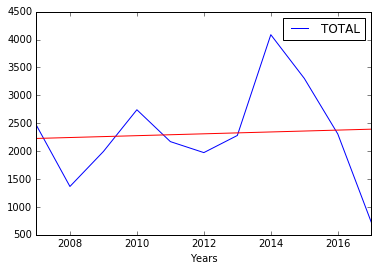

In [43]:
df_counts_pyear.plot(x="Years",y="TOTAL")
plt.plot(df_counts_pyear["Years"],slope*df_counts_pyear["Years"]+intercept,"-",color="red") 

# Without 2017

In [44]:
df_2007_2016 = df_counts_pyear[df_counts_pyear['Years'] != 2017]

In [45]:
lm = smf.ols(formula="TOTAL~Years",data=df_2007_2016).fit()

In [46]:
lm.params

Intercept   -254357.781818
Years           127.678788
dtype: float64

In [47]:
intercept, slope = lm.params

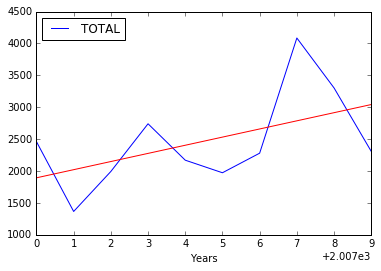

In [48]:
df_2007_2016.plot(x="Years",y="TOTAL")
plt.plot(df_2007_2016["Years"],slope*df_2007_2016["Years"]+intercept,"-",color="red")

In [263]:
df_2007_2016.to_csv('2007_2016_soz_de.csv')

# Harmonising at Gerichtsschreiber

In [68]:
def harm(elem):
    try:
        elem = elem.replace('R.', 'R')
        elem = elem.split('.')[0].replace('Gerichtsschreiber ', '').replace('Gerichtsschreiberin ', '')
        return elem
    except:
        return elem

In [69]:
df_bools['Schreiberharm'] = df_bools['Gerichtsschreiber'].apply(harm)

In [72]:
df_bools['Schreiberharm'].value_counts().head()

Batz         1171
Grünvogel     877
Fessler       876
R Widmer      670
Dormann       665
Name: Schreiberharm, dtype: int64

# Merging with large file to sort out Abgeschrieben/Nichteingetreten

In [137]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[['Aktennummer', 'Entscheid_harm']].copy()
df_ = df_bools.merge(df, left_on='Aktennummer', right_on='Aktennummer')
df_ = df_[df_['Entscheid_harm'] != 'Nicht eingetreten']

# Working out, total by Clerk

In [138]:
df_totalelems = pd.DataFrame(df_.groupby('Schreiberharm')['TOTAL'].sum().sort_values(ascending=False))

# Working out number of appeals, we counted their involvement in

In [166]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[df['Entscheid_harm'] != 'Nicht eingetreten']
df_sozrecht = df[df['recht_harm'] == 'Sozialrecht']
df_sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']

In [167]:
df_totalappeals = pd.DataFrame(df_sozrecht['Schreiber_harm'].value_counts())

# Merging total Elem Count with total Appeals by Clerk

In [168]:
df_final = df_totalelems.merge(df_totalappeals, how='left', left_index=True, right_index=True)

In [169]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS']]
df_final['Elem pCase'] = round(df_final['ELEM 500 COUNT'] / df_final['TOTAL APPEALS'], 1)

In [170]:
df_final.sort_values(by='Elem pCase', ascending=False).head(30)

,ELEM 500 COUNT,TOTAL APPEALS,Elem pCase
Schreiberharm,,,
Riedi Hunold,3194,310.0,10.3
Holzer,2506,260.0,9.6
Durizzo,3286,406.0,8.1
Nabold,1397,174.0,8.0
Furrer,1163,158.0,7.4
Wey,483,80.0,6.0
Williner,392,95.0,4.1
Grünenfelder,294,80.0,3.7
Attinger,640,201.0,3.2


# Gutheissungsquote nach Gerichtsschreiber

In [212]:
df_gut = pd.read_csv('soz_schreiber_stat.csv')

In [213]:
df_gut = df_gut[['Schreiber', 'Gutgeheissen %']].copy()
def remove(elem):
    elem = elem.replace('.', '')
    return elem
df_gut['Schreiber'] = df_gut['Schreiber'].apply(remove)
df_gut.index = df_gut['Schreiber']
del df_gut['Schreiber']

In [223]:
del df_final['Gutgeheissen %_y']
del df_final['Gutgeheissen %_x']

# Merge with final df

In [224]:
df_final = df_final.merge(df_gut, how='left', left_index=True, right_index=True)

In [232]:
df_final.sort_values(by='Elem pCase', ascending=False).head(50)
df_final = df_final[df_final['TOTAL APPEALS'] > 30]

In [236]:
#df_final.drop('Arnold', inplace=True)
df_final.drop('Grünvogel', inplace=True)
df_final.drop('Batz', inplace=True)

In [250]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS', 'ElempCase', 'Gutgeheissen']]

# Is there a correlation between amout of copy pasted elements and the percentage of successful appeals?

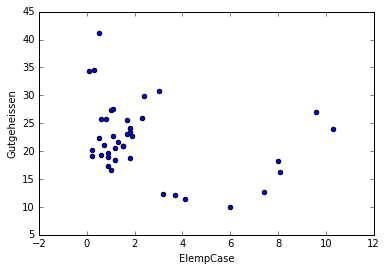

In [252]:
df_final.plot(kind='scatter', x='ElempCase', y='Gutgeheissen')

In [253]:
lm = smf.ols(formula="ElempCase~Gutgeheissen",data=df_final).fit()

In [254]:
intercept, slope = lm.params

In [258]:
lm.params

Intercept       5.112958
Gutgeheissen   -0.121644
dtype: float64

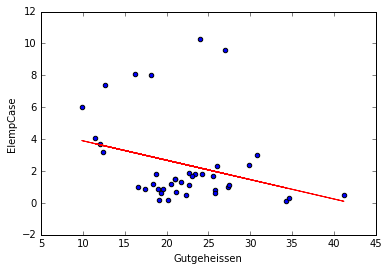

In [260]:
df_final.plot(kind='scatter', x="Gutgeheissen",y="ElempCase")
plt.plot(df_final["Gutgeheissen"],slope*df_final["Gutgeheissen"]+intercept,"-",color="red") 

In [261]:
df_final.to_csv('soz_500_de.csv')

In [ ]:
# Merge with french Data